<a href="https://colab.research.google.com/github/MarcScript/COVID-19-Paraguay-Cases-Prediction-with-Neural-LSTM-Network-/blob/main/Versi%C3%B3n_Final_Proyecto_Final_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final de Inteligencia Artificial
---
Este proyecto tiene como fin desarrollar una red recurrente tipo LSTM capaz de estimar correctamente el número total de casos de COVID-19 en Paraguay.

Estudiantes:

*   Marcos Ibañez - maibanez@fiuna.edu.py
*   Hugo Melgarejo - hmelgarejo@fiuna.edu.py

Docentes:

*   Profesor Encargado - Dr. Diego Stalder - stalderdiego@gmail.com 
*   Profesor Auxiliar - Ing. Enrique Paiva - epaiva@fiuna.edu.py

In [ ]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# Inicio del preprocesamiento de datos

## Importamos la base de datos de la universidad Johns Hopckins
La base de datos inicia el recuento de casos por país el 22 de enero del año 2020 y se va actualizando hasta la fecha, actualmente se disponen datos hasta el 14/05/2021.

In [ ]:
#Importamos la base de datos de la universidad Johns Hopkins
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
ds = pd.read_csv(url)
ds.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,57612,57721,57793,57898,58037,58214,58312,58542,58730,58843,59015,59225,59370,59576,59745,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,129307,129456,129594,129694,129842,129980,130114,130270,130409,130537,130606,130736,130859,130977,131085,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,119323,119486,119642,119805,119992,120174,120363,120562,120736,120922,121112,121344,121580,121866,122108,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12712,12771,12805,12805,12874,12917,12942,13007,13024,13060,13083,13121,13148,13198,13232,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24122,24300,24389,24518,24661,24883,25051,25279,25492,25609,25710,25942,26168,26431,26652,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933


In [ ]:
#Extraemos los parámetros que nos interesan
dataset = ds.loc[ds['Country/Region']=="Paraguay"] #Elegimos Paraguay entre los países debido a que es nuestro objeto de estudio
dataset.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21
207,NaN,Paraguay,-23.4425,-58.4438,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,244528,248364,250165,252443,255046,257706,260382,263134,265296,267082,269353,271814,274170,276865,279077,281023,282543,284453,286667,288974,291540,294233,296306,297789,299684,302061,304889,307457,309638,311746,313527,315547,318251,321032,324063,327229,330457,332971,335691,338914


In [ ]:
#Transponemos los datos para que quede una serie temporal
serie_temporal = dataset.iloc[:, 349:]
serie_temporal = serie_temporal.T
serie_temporal.rename(columns={207: 'Casos Totales'}, index={}, inplace= True)

# Normalizamos el dataset para disminuir el error
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(serie_temporal)
index = ds.columns.values
index = index[349:]
Y = scaler.inverse_transform(X)
print(serie_temporal.head())

        Casos Totales
1/1/21         108349
1/2/21         108718
1/3/21         109073
1/4/21         109837
1/5/21         110796


## Gráfico de situación actual.

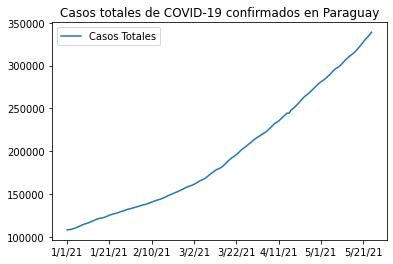

In [ ]:

serie_temporal.plot()
plt.title("Casos totales de COVID-19 confirmados en Paraguay")
plt.show()

## Separamos los datos en conjunto de entrenamiento y test

In [ ]:
split_percent = 0.90
split = int(split_percent*len(X))

train = X[:split]
test = X[split:]
date_train, date_test =  index[:split], index[split:]


In [ ]:
#Problema a solucionar, hacer que look_back sea mayor en el aprendizaje
# Realizamos reshape como X=t y Y=t+1
look_back = 1
train_generator = TimeseriesGenerator(train,train,length = look_back,batch_size=1)
test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=1)

#for i in range(len(train_generator)):
#	x, y = train_generator[i]
#	print('%s => %s' % (x, y))


# Creamos y entrenamos la red neuronal recurrente LSTM

In [ ]:
# Creamos la red neuronal LSTM
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
num_epochs = 50
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
129/129 [==============================] - 2s 2ms/step - loss: 0.1214
Epoch 2/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 3/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 4/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 5/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 6/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 7/50
129/129 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/50
129/129 [==============================] - 0s 2ms/step - loss: 9.4851e-04
Epoch 9/50
129/129 [==============================] - 0s 2ms/step - loss: 3.2783e-04
Epoch 10/50
129/129 [==============================] - 0s 2ms/step - loss: 9.2159e-05
Epoch 11/50
129/129 [==============================] - 0s 2ms/step - loss: 5.1832e-05
Epoch 12/50
129/129 [==============================] - 0s 2ms/step - loss: 4.7178e-05
Epoch

# Visualizamos la predicción realizada por el modelo

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report 
prediction = model.predict_generator(test_generator)


train = Y[:split]
test = Y[split:]
prediction = scaler.inverse_transform(prediction)
prediction = prediction.reshape((-1))
train = train.reshape((-1))
test = test.reshape((-1))
error = prediction - test[:-1]



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
import plotly.graph_objects as go
trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predicción de casos totales de COVID-19 en Paraguay",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de casos confirmados"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
#Limitar cantidad de días
#Histograma de error

# Revisamos las métricas del modelo para corroborar su correcto desempeño

In [ ]:
def evaluate_model(model, generator):
    score = model.evaluate_generator(generator=generator,           # Generator yielding tuples
                                     steps=1)   # number of steps (batches of samples) to yield from generator before stopping
    print(score)

evaluate_model(model,train_generator)
evaluate_model(model,test_generator)


2.7801035685115494e-05
4.2830877646338195e-05


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



# Forecasting

In [ ]:


close_data = index
close_data = close_data.reshape((-1,1))
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    #last_date = df['Date'].values[-1]
    last_date = index[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1)
    return prediction_dates

num_prediction = 5
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

forecast_dates = forecast_dates.strftime("%x")
#.tolist()
print(forecast_dates)
forecast = forecast.reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
forecast = forecast.reshape((-1))
print(forecast)

In [ ]:
trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Future prediction'
)
layout = go.Layout(
    title = "Predicción de casos totales de COVID-19 en Paraguay",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de casos confirmados"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4], layout=layout)
fig.show()
 #Agregar porcentaje de error
 #Saber tipo de sezgo

# Bibliografía


*  Predicción de series temporales utilizando redes LSTM [machinelearningmastery.com](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
*  Repositorio COVID-19 de la universidad John Hopckins
[CSSEGISandData](https://github.com/CSSEGISandData)

